# Enhancing $\psi(2S)$ signal with a simple DNN

In the previous notebooks we have discussed the basics of `numpy`, `pandas` and `matplotlib` which provide the minimal toolset for data analysis in Python. 
Then we introduced `keras` to define and train deep neural networks. 

In this notebook we discuss a first application of keras to *Particle Physics* to enhance the signal of the $\psi(2S)$ resonance by rejecting background combining kinematic variables. 

## Loading libraries and datasets

As a first step, let's load the libraries of our toolset

In [1]:
## numpy for arrays and numerical operations 
import numpy as np 

## pandas for data handling 
import pandas as pd 

## pyplot for data visualization 
import matplotlib.pyplot as plt

## keras for deep learning
import keras as K

Then we obtain the dataset from the CERN Open Data portal ed elenchiamo le variabili presenti nel dataset.

In [2]:
df = pd.read_csv ("https://opendata.cern.ch/record/5201/files/Dimuon_DoubleMu.csv")

print ("\n".join (df.columns))

Run
Event
type1
E1
px1
py1
pz1
pt1
eta1
phi1
Q1
type2
E2
px2
py2
pz2
pt2
eta2
phi2
Q2
M


## Explorative analysis and Feature engineering
With the exception of the mass $M$, all variables are relative to either the positive or the negative muon combined into a charmonium decay candidate.
We compute the momentum and the polar angle of the combination.

In [3]:
df['p'] = df.eval("sqrt((px1 + px2)**2 + (py1 + py2)**2 + (pz1 + pz2)**2)")
df['pT'] = df.eval("sqrt((px1 + px2)**2 + (py1 + py2)**2)")
df['theta'] = df.eval(f"arcsin (pT/p) * 180 / {np.pi}")

Now that we have engineered some useful feature in our dataset let's consider the mass distribution in the charmonium region.

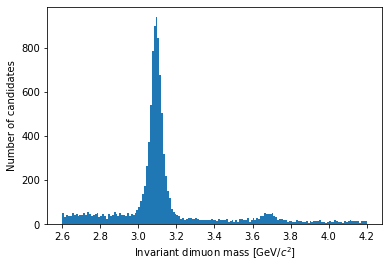

In [4]:
boundaries = np.linspace ( 2.6, 4.2, 161)
plt.hist (df['M'], bins=boundaries)
plt.xlabel ("Invariant dimuon mass [GeV/$c^2$]")
plt.ylabel ("Number of candidates")
plt.show()

We define now a background region, a control region and a signal region. 
The background region is assumed to represent reliably the residual background in the signal and in the control region. 
While the signal region offers a dataset with abundant and relatively pure decay candidates that represents well the signal. 
> **Note!** This is possible because the production mechanism of $J/\psi$ and $\psi(2S)$ is similar with differences mainly due to the small mass difference.

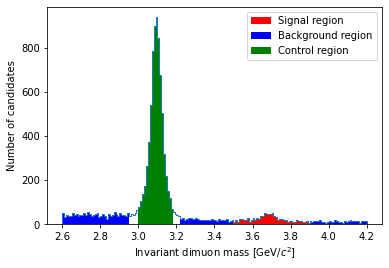

In [5]:
df_bkg = df.query ("(M > 2.6 and M < 2.95) or (M > 3.22 and M < 3.5) or (M > 3.9 and M < 4.2)").copy()
df_ctrl = df.query ("M > 3.0 and M < 3.18").copy()
df_sig = df.query ("M > 3.5 and M < 3.9").copy()
boundaries = np.linspace ( 2.6, 4.2, 161)

plt.hist (df['M'], bins=boundaries, histtype = 'step')

plt.hist (df_sig['M'], bins=boundaries, color = 'red', label = "Signal region")
plt.hist (df_bkg['M'], bins=boundaries, color = 'blue', label = "Background region")
plt.hist (df_ctrl['M'], bins=boundaries, color = 'green', label = "Control region")

plt.xlabel ("Invariant dimuon mass [GeV/$c^2$]")
plt.ylabel ("Number of candidates")
plt.legend()
plt.show()

We will try to distinguish the control sample from the combinatorial background by applying selection requirements on the kinematic variables that we engineered above: the mass and the momentum of the dimuon combination.
Let's have a look to how the three categories are distributed on the $p \perp \theta$ plane.

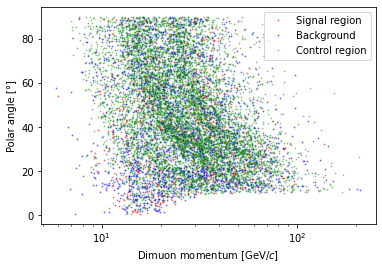

In [6]:
plt.plot (df_sig['p'], df_sig['theta'], '.', alpha=0.4, markersize=2, color='red', label="Signal region")
plt.plot (df_bkg['p'], df_bkg['theta'], '.', alpha=0.4,  markersize=2, color='blue', label="Background")
plt.plot (df_ctrl['p'], df_ctrl['theta'], '.', alpha=0.3,  markersize=2, color='green', label="Control region")
plt.legend()
plt.xscale('log')
plt.xlabel ("Dimuon momentum [GeV/$c$]")
plt.ylabel ("Polar angle [°]")
plt.show()

## Preprocessing 

Instead of using directly the momentum and the angle, we may *preprocess* them in order to make it easier for the minimization procedure to reach the minimum. 
We define two variables `prep_p` and `prep_theta` obtained as a bijective transformation of `p` and `theta` that maps the two variables to distributions "not too different" from a standard Gaussian ($\frac{1}{\sqrt{2\pi}}\exp(-0.5 x^2)$). 

Standardization is a common *preprocessing* procedure:
$$
x' = \frac{x - E(x)}{\sqrt{E^2(x) - E(x)^2}}
$$
where $E$ represents the expectation value (`np.mean`) and the denominator is the standard deviation of the dataset (`np.std`).

For the momentum, the very long tail at high momentum my be difficult to treat even if preprocessed with a linear transform. Hence, we transform the momentum $p$ to $\log (p)$ and then we *standardize* $\log (p)$.

In Python,


In [7]:
p = df['p']
th = df['theta']

df['prep_p'] = (np.log(p) - np.log(p.mean()))/(np.log(np.std(p)))
df['prep_theta'] = (th - th.mean())/(np.std(th))

Let's plot the standardized variables.

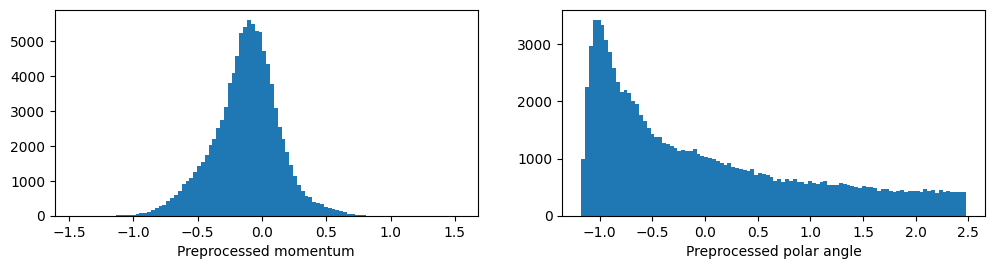

In [8]:
plt.figure (figsize = (12,6), dpi = 100)
plt.subplot(221)
plt.hist (df['prep_p'], bins = 100)
plt.xlabel ("Preprocessed momentum")
plt.subplot(222)

plt.hist (df['prep_theta'], bins = 100)
plt.xlabel ("Preprocessed polar angle")
plt.show()

Finally, we propagate these variables to the dataset obtained through queries to the original dataset, in order to ensure a consistent transoformation of the variables in all the datasets.

In [9]:
df_bkg = df.query ("(M > 2.6 and M < 2.95) or (M > 3.22 and M < 3.5) or (M > 3.85 and M < 4.2)").copy()
df_ctrl = df.query ("M > 3.0 and M < 3.18").copy()
df_sig = df.query ("M > 3.5 and M < 3.9").copy()


## Logistic regression as a special neural network

Let's define a function to instanciate a keras model as discussed in the previous lecture. 
We will take as arguments the number of layers and the number of nodes per layer, assuming all layers share the same number of nodes. 

We will use `tanh` as activation function for the hidden layers which is better suited for small and shallow neural networks, all the other settings are quite standard:
 * Adam optimizer
 * Binary cross-entropy as loss function for binary classification problems

In [10]:
def create_model (n_layers=1, n_nodes=32):
    inputs = K.layers.Input(shape=(2))
    layers = [inputs]
    for iLayer in range(n_layers): 
        layers.append(K.layers.Dense(n_nodes, activation='tanh') (layers[-1]))

    outputs = K.layers.Dense(1, activation = 'sigmoid')(layers[-1])

    model = K.models.Model (inputs=inputs, outputs=outputs)
    model.compile(loss='binary_crossentropy', optimizer='adam')

    return model

Before diving into the depth of the neural network, let's focus on the case 
`n_layers=0`. The resulting algorithm is known as logistic regression. 
Note that since there are no non-linear elements (with the exception of the `sigmoid` which is only applied to the output layer) this is considered as a linear classification algorithm.

The prediction $\hat y$ is defined by
$$
\hat y = \mathrm{sigmoid} ( a p + b \theta + c)
$$
where $a$, $b$ and $c$ are parameters to be optimized during the training, $p$ and $\theta$ are the preprocessed versions of the momentum and polar angle of our dimuon combination.

With `lr.summary()` we obtain confirmation that the total number of parameters defining the model is indeed 3.


In [11]:
lr = create_model (n_layers=0)
lr.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


## Dataset preparation
We are now ready to convert the `pandas` dataframe in `numpy` arrays that can transparently be processed by keras.

First of all, we identify the control sample with unit labels, while the background candidates are identified by null labels. 

Then we use obtain the arrays from pandas using the `values` property, and finally we shuffle the signal and background events by defining a random permutation of the indices and shuffling variables and labels by the same permutation.

In [12]:
df_ctrl['label'] = 1
df_bkg['label'] = 0

X = np.concatenate ( [ df_ctrl[['prep_p', 'prep_theta']].values , df_bkg[['prep_p', 'prep_theta']].values ] ) 
y = np.concatenate ( [ df_ctrl['label'].values , df_bkg['label'].values ] ) 

indices = np.random.permutation (len(X))

X = X[indices]
y = y[indices]

We are finally ready to train the logistic regression on our data.


In [13]:
history_lr=lr.fit (X, y, validation_split=0.5, epochs=150, verbose=True)

Epoch 1/150
152/152 [==============================] - 1s 5ms/step - loss: 1.0257 - val_loss: 0.9514
Epoch 2/150
152/152 [==============================] - 0s 2ms/step - loss: 0.9296 - val_loss: 0.8530
Epoch 3/150
152/152 [==============================] - 0s 2ms/step - loss: 0.8232 - val_loss: 0.7732
Epoch 4/150
152/152 [==============================] - 0s 2ms/step - loss: 0.7603 - val_loss: 0.7125
Epoch 5/150
152/152 [==============================] - 0s 2ms/step - loss: 0.6958 - val_loss: 0.6673
Epoch 6/150
152/152 [==============================] - 0s 2ms/step - loss: 0.6633 - val_loss: 0.6343
Epoch 7/150
152/152 [==============================] - 0s 2ms/step - loss: 0.6219 - val_loss: 0.6120
Epoch 8/150
152/152 [==============================] - 1s 4ms/step - loss: 0.6089 - val_loss: 0.5966
Epoch 9/150
152/152 [==============================] - 1s 4ms/step - loss: 0.5875 - val_loss: 0.5864
Epoch 10/150
152/152 [==============================] - 1s 4ms/step - loss: 0.5752 - val_lo

152/152 [==============================] - 1s 4ms/step - loss: 0.5546 - val_loss: 0.5649
Epoch 82/150
152/152 [==============================] - 1s 4ms/step - loss: 0.5570 - val_loss: 0.5649
Epoch 83/150
152/152 [==============================] - 1s 4ms/step - loss: 0.5596 - val_loss: 0.5650
Epoch 84/150
152/152 [==============================] - 0s 3ms/step - loss: 0.5613 - val_loss: 0.5650
Epoch 85/150
152/152 [==============================] - 1s 4ms/step - loss: 0.5653 - val_loss: 0.5650
Epoch 86/150
152/152 [==============================] - 1s 3ms/step - loss: 0.5596 - val_loss: 0.5650
Epoch 87/150
152/152 [==============================] - 0s 3ms/step - loss: 0.5591 - val_loss: 0.5650
Epoch 88/150
152/152 [==============================] - 1s 4ms/step - loss: 0.5649 - val_loss: 0.5650
Epoch 89/150
152/152 [==============================] - 1s 4ms/step - loss: 0.5508 - val_loss: 0.5650
Epoch 90/150
152/152 [==============================] - 1s 5ms/step - loss: 0.5731 - val_loss: 

Let's plot the evolution of the binary cross-entropy with the epochs.

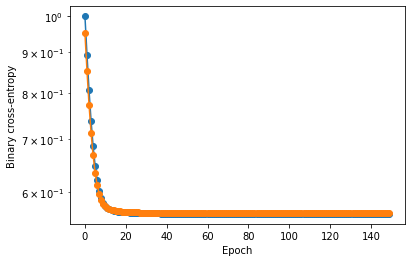

In [14]:
plt.plot (history_lr.history['loss'], 'o-', label="Training")
plt.plot (history_lr.history['val_loss'], 'o-', label="Validation")

plt.yscale('log')
plt.xlabel ( "Epoch")
plt.ylabel ( "Binary cross-entropy")

plt.show()

We observe that the slope at the end of training is basically null, which may indicate that the training procedure reached the minimum of the loss function.

We can then explore the response of the logistic regression.

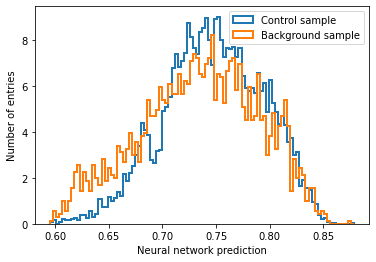

In [15]:
X_ctrl = df_ctrl[['prep_p', 'prep_theta']].values
y_ctrl = lr.predict(X_ctrl)

X_bkg = df_bkg[['prep_p', 'prep_theta']].values
y_bkg = lr.predict(X_bkg)

h_ctrl, boundaries, _ = plt.hist (y_ctrl, density=True, bins=100, label="Control sample", histtype='step', linewidth=2)
h_bkg, _, _ = plt.hist (y_bkg, density=True, bins=boundaries, label="Background sample", histtype='step', linewidth=2)
plt.legend()
plt.xlabel ("Neural network prediction")
plt.ylabel ("Number of entries")
plt.show()

The histogram indicates already the the separation between signal in the control sample and the background is not exciting, but we observe that the histogram representing the control sample is, as expected, slightly at the right of the background. 

It is customary to study the hability of the classification algorithm to distinghish signal from noise using the *Receiver Operator Curve (ROC)*: the curve obtained plotting the background rejection versus the signal efficiency for different working points of the binary classification algorithm.

We plot below the ROC of the Logistic Regression algorithm, superposed to the result expected by drawing randomly events from the dataset and calling them signal events.

The area under the ROC (*Area under the curve*) is a metric of how well the algorithm is able to separate signal and background, independently of the threshold chosen to call a candidate *signal* or *background*.

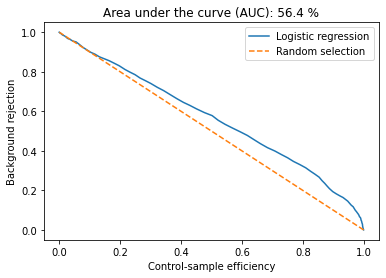

In [16]:
plt.plot (1.- np.cumsum(h_ctrl)/h_ctrl.sum(), np.cumsum(h_bkg)/h_bkg.sum(), label="Logistic regression" )
auc = np.trapz (1.- np.cumsum(h_ctrl)/h_ctrl.sum(), np.cumsum(h_bkg)/h_bkg.sum() )
plt.plot ([1,0], [0,1], '--', label = "Random selection")
plt.xlabel ("Control-sample efficiency")
plt.ylabel ("Background rejection")
plt.title ( f"Area under the curve (AUC): {auc*100:.1f} %")
plt.legend()
plt.show()

## Application
We are now ready to apply the trained logistic regression to the signal sample.

First we obtain the prediction `y_hat` for each row of the signal dataframe and register it as a new column of this derived datasets.



In [17]:
X_sig = df_sig[['prep_p', 'prep_theta']].values
y_hat = lr.predict (X_sig).flatten()
df_sig ['y_hat'] = y_hat

Then we plot the histogram and select some threshold to scan the effect of a cut on the response obtained from the logistic regression on the invariant mass distribution.

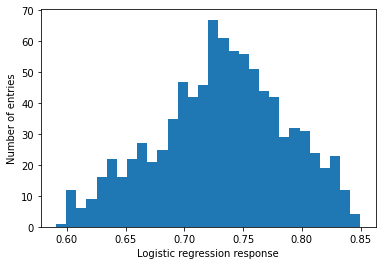

In [18]:
plt.hist (y_hat, bins = 30)
plt.xlabel("Logistic regression response")
plt.ylabel("Number of entries")
plt.show()

We use the function `quantile` to get a sequence of thresholds that divide the sample in equal parts. 

Then we loop over the threshold and draw the histograms obtained by cutting on the logistic regression response.

We note that with the softer cuts we are able to remove background without affecting the signal component.

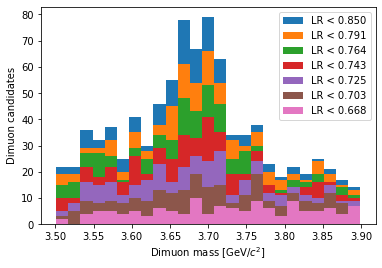

In [19]:
thresholds = np.quantile (y_hat, np.linspace(1, 0, 8))
for threshold in thresholds[:-1]:
    plt.hist (df_sig['M'][y_hat < threshold], bins = 25, label = f"LR < {threshold:.3f}")
plt.legend()
plt.xlabel ("Dimuon mass [GeV/$c^2$]")
plt.ylabel ("Dimuon candidates")
plt.show()

## Map of the selection
Since we are using two variables only, we can superpose the decision of the neural network to the distribution of the dataset on the plane $p \perp \theta$.
From this excercise it should be evident the "linearity" of the logistic regression.

> In short, the algorithm (the logistic regression or the neural network) defines the shape of the *boundaries* with the optimization of the figure of merit we select *which* boundary separates the two classes.

In [20]:
def make_plot (p, theta, yNN):
    plt.plot (df_sig['p'], df_sig['theta'], '.', alpha=0.4, markersize=2, color='red', label="Signal region")
    plt.plot (df_bkg['p'], df_bkg['theta'], '.', alpha=0.4,  markersize=2, color='blue', label="Background")
    plt.plot (df_ctrl['p'], df_ctrl['theta'], '.', alpha=0.3,  markersize=2, color='green', label="Control region")

    plt.contour (p, theta, yNN.reshape(p.shape), cmap='coolwarm', levels=10, alpha=1, linewidths=3)
  
    plt.legend()
    plt.xscale('log')
    plt.xlabel ("Dimuon momentum [GeV/$c$]")
    plt.ylabel ("Polar angle [°]")
    plt.show()

pAxis = 10**np.linspace (0.5, 2.5, 100)
thetaAxis = np.linspace (0, 90, 100)
p, theta = np.meshgrid (pAxis, thetaAxis)

prep_p = (np.log(p) - np.log(df['p'].mean()))/(np.log(np.std(df['p'])))
prep_theta = (theta - theta.mean()) / np.std(theta)

yNN = lr.predict ((np.stack([prep_p.flatten(), prep_theta.flatten()], axis = -1)))
plt.title (f"AUC: {history_lr.history['val_auc'][-1]:.3f}")
make_plot (p, theta, yNN)

KeyError: 'val_auc'